In [267]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True) #Want to be able to use tex in the plot labels
%matplotlib inline
import seaborn

seaborn.set_style('ticks')
seaborn.set_color_codes()

### What is a Markov chain Monte Carlo sampler?

To understand what an MCMC is, and what it's for, we first have to talk about Bayesian probability theory, which really boils down to one simple equation: Bayes' Theorem (CITE the rev):

\begin{equation}
p(A|B) = \frac{p(B|A)p(A)}{p(B)}
\end{equation}

This equation states that the probability of event $A$ given event $B$ is equal to the probability of $B$ given $A$ (the **likelihood** of B), multiplied by the probability of $A$ without observing $B$ (the **prior** on $A$), divided by the probability of $B$ without considering $A$ (the **evidence** or **fully marginalized likelihood (FML)**).  

Now, instead of two events, think of $A$ as a model and $B$ as a piece of data. This is now the equation for the probability that $A$ is the correct model, given observation $B$. We'll switch to $\mathcal{M}$ and $d$ for clarity. Finally, assume that $\mathcal{M}$ is a model that is parameterized by the parameter, $\theta$. What we are often looking for in this case is the *posterior distribution* for $\theta$ - this is the inferred probability distribution on the parameter after we've made an observation. So
\begin{equation}
p(\theta|d,\mathcal{M}) = \frac{p(d|\mathcal{M},\theta) p(\theta)}{p(d,\mathcal{M})}.
\end{equation}
The term on the denominator is, again, the evidence, and is defined via
\begin{equation}
p(d,\mathcal{M}) = \int p(d|\mathcal{M},\theta) p(\theta) d\theta
\end{equation}
The integration over $\theta$ is called *marginalization*. In the case of parameter estimation, this factor serves as a normalizing constant - because the posterior distribution is a probability density, it must integrate to one. 

This integral is often super nasty! In most interesting data analysis problems, it is not tractible analytically, and is either quite high-dimensional, multi-modal, steeply peaked, or all of these things. This means that standard numerical integration techniques are not sufficient. This is where MCMC's come in! 

In the context of Bayesian inference, an MCMC is a way to avoid doing an integral, and it is magic. 

**HERE IS WHERE YOU FILL IN A DESCRIPTION OF MCMC**

(There are lots of great resources for learning about Bayes' theorem (LIST), and I don't aim to be one of them. What I want to do in this Notebook is give a basic understanding of how MCMC's are used in Bayesian analysis.)

### Generating Samples from a Distribution

As discussed above, MCMC is used in Bayesian inference to avoid having to calculate the fully marginalized likelihood, which is aptly initialized as FML. But what we're *really* doing is generating samples from the posterior distribution. And this is what MCMC is really for - generating samples from a given distribution.

This may sound odd, but think about it for a moment - if I can write down a probability distribution, say the shifted Student-t
\begin{equation}
p(x|\nu,\sigma,\mu) = \frac{\Gamma((\nu +1)/2}{\sqrt{\nu \pi \sigma^2}\Gamma(\nu/2)} \left(1 +\frac{1}{\nu} \left( \frac{x-\mu}{\sigma} \right)^2 \right),
\end{equation}
How on Earth do I generate samples from this distribution? That is, how do I write down a set of numbers that are drawn with exactly this probability? (If this is still confusing: if I have a large number of samples, I want the histogram of these samples to look like the probability distribution.)

For our first example, we will use MCMC to do exactly that. We will generate samples from the above function, with $\nu = 3$, $\mu=1$, and $\sigma = 1$.

**First, we define the likelihood:**

In [268]:
def like(x):                  #x is read in to this function
    nu = 3.                   #the parameters of the distribution are fixed
    sigma = 1.
    mu = 2.
    
    norm = np.sqrt(nu*np.pi*sigma*sigma)
    ratio = sp.special.gamma((nu+1.)/2.)/sp.special.gamma(nu/2.)
    
    px = ratio*(1.+(1./nu)*((x-mu)**2)/sigma)**(-(nu+1.)/2.)/norm
    
    return px

**What about the proposal distribution?**

If we have infinite time to wait, any proposal distribution will eventually produce samples distributed in the way we want (with a couple of caveats). But we typically don't have the age of the universe to wait, and so one of the key points of the black art of MCMC design is implementing proposal distributions that lead to faster convergence.

To explore what we mean by 'fast convergence,' and some of the choices we can make in proposal distributions, we will use a Gaussian proposal distribution with variance $\alpha$:
\begin{equation}
q(y|x) = \frac{1}{\sqrt{2\pi\alpha^2}} e^{-(y-x)^2/2\alpha^2}.
\end{equation}
This distribution is symmetric upon exchange of $x$ and $y$, and so the calculation of the Metropolis-Hastings ratio is quite simple.

We are going to run an MCMC for 1000 iterations with different values of $\alpha$, and then look at the chains, the distribution of the samples, and the acceptance rates to learn a little about proposal design.

In [269]:
def prop(x,alpha):          #needs current location (x), and variance of Gaussian (alpha)
    return np.random.normal(loc=x,scale=alpha)
    

In [270]:
Nstep = 2000                #number of iterations for which to run the chain
xstart = 0.                 #gotta start somewhere
alpha = 10.0                #variance for prop. dist.

samples10 = []              #empty list to store the samples
Nacc = 0.                   #counter for accepted jumps
x = xstart
for i in range(Nstep):      #for loop is the actual sampling process
    lx = like(x)            #likelihood at x 
    y = prop(x,alpha)       #propose a new value - y
    ly = like(y)            #likelihood at y
    r = np.random.rand()
    if ly/lx > r:           #compare the Hastings ratio (in this case just the likelihood ratio) to random number r.
        x = y               #if H>r, accept the jump.
        Nacc += 1.          #iterate the acceptance counter
    samples10.append(x)     #whether the jump was accepted or not, the current value of x is a new sample.
AR10 = Nacc/Nstep           #calculate the acceptance rate.

In [271]:
#Rinse and repeat for three other values of alpha: 1, 0.1, and 0.01
alpha = 1.0    
samples1 = []
Nacc = 0.
x = xstart
for i in range(Nstep):
    lx = like(x)
    y = prop(x,alpha)
    ly = like(y)
    r = np.random.rand()
    if ly/lx > r:
        x = y
        Nacc += 1.
    samples1.append(x)
AR1 = Nacc/Nstep
 

alpha = .1    
samples01 = []
Nacc = 0.
x = xstart
for i in range(Nstep):
    lx = like(x)
    y = prop(x,alpha)
    ly = like(y)
    r = np.random.rand()
    if ly/lx > r:
        x = y
        Nacc += 1.
    samples01.append(x)
AR01 = Nacc/Nstep
    

alpha = .01    
samples001 = []
Nacc = 0.
x = xstart
for i in range(Nstep):
    lx = like(x)
    y = prop(x,alpha)
    ly = like(y)
    r = np.random.rand()
    if ly/lx > r:
        x = y
        Nacc += 1.
    samples001.append(x)
AR001 = Nacc/Nstep

samples10 = np.array(samples10)
samples1 = np.array(samples1)
samples01 = np.array(samples01)
samples001 = np.array(samples001)

First, let's look at the **acceptance ratios**. 

Obviously, you want to be able to generate a lot of samples from the desired distribution without wasting too many iterations on jump proposals that are rejected. So a high acceptance ratio seems like it would be good.

In [272]:
print 'alpha = 10 AR =', AR10
print 'alpha = 1 AR =',AR1
print 'alpha = 0.1 AR =',AR01
print 'alpha = 0.01 AR =', AR001

alpha = 10 AR = 0.158
alpha = 1 AR = 0.732
alpha = 0.1 AR = 0.975
alpha = 0.01 AR = 0.9955


And we get some really high acceptance ratios! From this alone, we may think that the proposal distribution with the smallest alpha is the best - almost every single jump proposal was accepted!

Let's look at the chains to dig a little deeper.

**Plot the chains:**

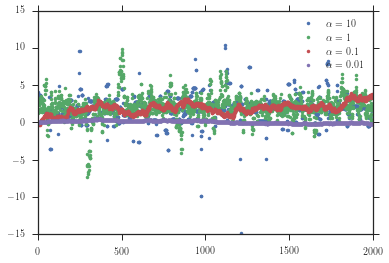

In [273]:
plt.plot(samples10,marker='.',linestyle='None',label =r'$\alpha=10$')
plt.plot(samples1,marker='.',linestyle='None',label =r'$\alpha=1$')
plt.plot(samples01,marker='.',linestyle='None',label =r'$\alpha=0.1$')
plt.plot(samples001,marker='.',linestyle='None',label =r'$\alpha=0.01$')
plt.legend()

It's pretty clear from thie graph that the proposal distributions with very small $\alpha$ are not exploring very much of the space. We can also see the effect of that very low acceptance ratio for $\alpha = 10$ - there are lots of 'clumps' of points in the blue chain. From this graph, it looks like $\alpha=1.0$ is doing the best job exploring the space, even though its acceptance ratio is not the highest.

Let's look now at the histogram for each of our samples, compared to the target distribution

In [274]:
xplot = np.linspace(-10,10,5000)      #Need an x axis for plotting
target = like(xplot)                   #target distribution

First, we look at $\alpha = 10.$ As expected, we see a lot of sharp peaks in the distribution, which reflects the 'clumpiness' of the chain. We have, though, at least explored the bulk of the x range in which the target distribution has non-negligible support

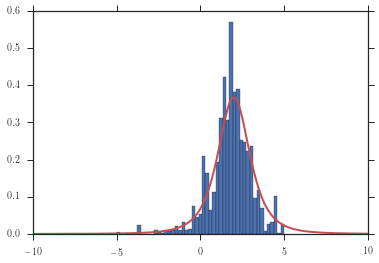

In [275]:
edges = np.linspace(-5,5,50)
a,b,c = plt.hist(samples10,bins=edges,normed=True)
plt.plot(xplot,target,lw=2,color='r')

In the next two graphs, we look ath the distributions for $\alpha = 0.1$ and $\alpha = 0.01$. Again, consistent with what we can see in the chains, it is clear that neither of these distributions have come anywhere close to exploring the full space. These are not good representations of the target distribution.

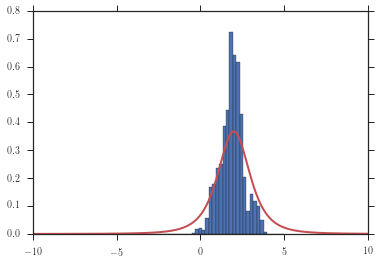

In [276]:
edges = np.linspace(-5,5,50)
a,b,c = plt.hist(samples01,bins=edges,normed=True)
plt.plot(xplot,target,lw=2,color='r')

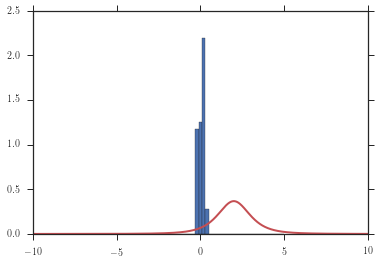

In [277]:
edges = np.linspace(-5,5,50)
a,b,c = plt.hist(samples001,bins=edges,normed=True)
plt.plot(xplot,target,lw=2,color='r')

Finally, we have our goldilocks distribution: $\alpha = 1.0$. While it has not perfectly recovered the target distribution by any means, it is a much better approximation than the other three.

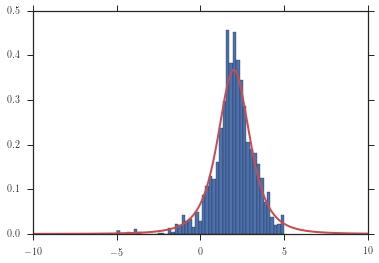

In [278]:
edges = np.linspace(-5,5,50)
a,b,c = plt.hist(samples1,bins=edges,normed=True)
plt.plot(xplot,target,lw=2,color='r')

**Note: this does not mean that there is anything wrong with our proposal distribution or sampler!** 

To see this, we now run the $\alpha = 0.1$ and the $\alpha = 10$ samplers for $1e6$ iterations.

In [279]:
Nstep = 1e6
Nstep = int(Nstep)

alpha = 10.
samples10long = []              
x = xstart
for i in range(Nstep):     
    lx = like(x)            
    y = prop(x,alpha)       
    ly = like(y)            
    r = np.random.rand()
    if ly/lx > r:           
        x = y               
    samples10long.append(x)     


alpha = .1    
samples01long = []
x = xstart
for i in range(Nstep):
    lx = like(x)
    y = prop(x,alpha)
    ly = like(y)
    r = np.random.rand()
    if ly/lx > r:
        x = y
    samples01long.append(x)


$\alpha = 0.1$ first, then $\alpha = 10.$:

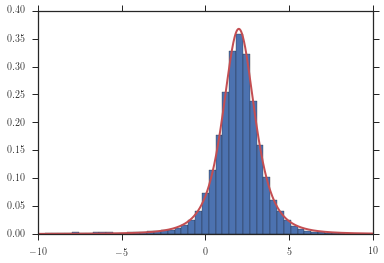

In [280]:
edges = np.linspace(-10,10,50)
a,b,c = plt.hist(samples01long,bins=edges,normed=True)
plt.plot(xplot,target,lw=2,color='r')

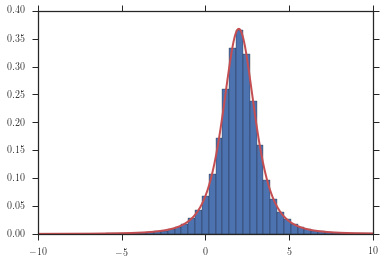

In [281]:
edges = np.linspace(-10,10,50)
a,b,c = plt.hist(samples10long,bins=edges,normed=True)
plt.plot(xplot,target,lw=2,color='r')

Just as we hoped, we see that, *eventually*, even really terrible samplers will return the target distribution. (So long as they are Markovian and give access to the entire parameter space!)

When looking at the original chains for the low-$\alpha$ proposal distributions, it was clear that the chain 'wasn't moving around very much.' In math-speak, this means that it has a *high autocorrelation* - the value at point n is a good predictor of the value at point n+1. 

If we define the quantity
\begin{equation}
\gamma(h) = \frac{1}{N-h}\sum^{N-h}_{i=1} (x_{i+h} - \bar{x})(x_i - \bar{x}),
\end{equation}
where $N$ is the number of samples, $\{ x\}$ is the set of samples, and $\bar{x}$ is the sample mean (note that with these definitions, $\gamma(0)$ is just the sample variance), then the autocorrelation length is roughly the value of $h$ at which the ratio,
\begin{equation}
\rho(h) = \frac{\gamma(h)}{\gamma(0)},
\end{equation}
drops to $\sim0.01$.

Let's compute the autocorrelation length for the short chains we generated at the beginning of this notebook

In [282]:
def gammacorr(x,h):
    x = np.array(x)
    N = len(x)
    smean = np.mean(x)         #calculate the sample mean
    xshift = x[h:].copy()      #shifted samples
    xnew = x[0:N-h].copy()     #shortened samples
    
    xshift -= smean            #subtract the sample mean
    xnew -= smean
    
    gh = (1./float(N-h))*np.dot(xshift,xnew)       #calculate gamma
    
    return gh

In [287]:
samples = samples1.copy()
gval = np.var(samples)
svar = np.var(samples)
rho = gval/svar
acl = 0
while rho>0.01:
    acl += 1
    gval = gammacorr(samples,acl)
    rho = gval/svar
print acl

31


In [288]:
samples = samples10.copy()
gval = np.var(samples)
svar = np.var(samples)
rho = gval/svar
acl = 0
while rho>0.01:
    acl += 1
    gval = gammacorr(samples,acl)
    rho = gval/svar
print acl

32


In [289]:
samples = samples01.copy()
gval = np.var(samples)
svar = np.var(samples)
rho = gval/svar
acl = 0
while rho>0.01:
    acl += 1
    gval = gammacorr(samples,acl)
    rho = gval/svar
print acl

171


In [290]:
samples = samples001.copy()
gval = np.var(samples)
svar = np.var(samples)
rho = gval/svar
acl = 0
while rho>0.01:
    acl += 1
    gval = gammacorr(samples,acl)
    rho = gval/svar
print acl

624


The autocorrelation lengths essentially follow the pattern we would expect from inspecting the chains by eye.

To choose the 'correct' value for $\alpha$, we can use the Fisher information matrix (1x1 matrix for this case), which is essentially the quadratic approximation to the likelihood. It tells us the variance of the best-fit Gaussian to the target distribution.

The Fisher matrix is defined in general by
\begin{equation}
\Gamma_{ij} \partial_i \partial_j \log (\rm{like})|_{\rm{max}}.
\end{equation}
Each component is defined as the second derivative of the log of the likelihood function, evaluated at the peak of the likelihood. The inverse of this matrix is the *covariance matrix*, which gives the values of $\sigma$ for each parameter for a Gaussian distribution.

In [ ]:
def Fisher()